# JointMatch for Freesound Audio Tagging

This notebook implements the JointMatch algorithm for semi-supervised audio classification on the Freesound dataset. It adapts the structure from a previous EPASS implementation and incorporates the key concepts of JointMatch:

1.  **Adaptive Local Thresholding:** Dynamically adjusts confidence thresholds for pseudo-labeling based on class learning status.
2.  **Cross-Labeling:** Utilizes two differently initialized models that teach each other.
3.  **Weighted Disagreement & Agreement Update:** Weights the unsupervised loss to prioritize disagreement samples, maintaining model diversity while still leveraging agreement samples.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import itertools
import math
import copy

In [2]:
# ----------------------------
# 1. Configuration
# ----------------------------
class Config:
    def __init__(self):
        # Audio & Spectrogram Params
        self.sr = 32000           # Audio sample rate
        self.duration = 5         # Audio duration (seconds)
        self.n_mels = 128         # Number of Mel bands
        
        # Training Params
        self.batch_size = 16      # Combined batch size (adjust per GPU memory)
        self.epochs = 30           # Number of epochs (adjust as needed)
        self.lr = 1e-4            # Learning rate
        self.num_classes = 41     # Number of classes (as per train.csv)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Semi-Supervised Params
        self.num_labeled_per_class = 25 # Number of labeled samples per class
        self.mu = 7               # Ratio of unlabeled to labeled samples per batch (unlabeled_bs = mu * labeled_bs)
        self.wu = 1.0             # Unsupervised loss weight
        self.threshold = 0.95     # Base confidence threshold (tau)
        self.ema_decay = 0.999    # EMA decay rate (lambda)
        self.delta = 0.8          # Disagreement weight (delta > 0.5 gives more weight to disagreement)
        
        # SpecAugment Params (for strong augmentation)
        self.freq_mask_param = 27
        self.time_mask_param = 70 # Adjusted based on spectrogram width
        
        # Model Saving
        self.model_save_path_f = "best_model_f.pth"
        self.model_save_path_g = "best_model_g.pth"
        
        # Calculated params
        self.labeled_batch_size = self.batch_size // (self.mu + 1)
        self.unlabeled_batch_size = self.batch_size - self.labeled_batch_size
        
        # Data paths (update if necessary)
        self.train_csv_path = "/kaggle/input/freesound-audio-tagging/train.csv"
        self.test_csv_path = "/kaggle/input/freesound-audio-tagging/test_post_competition.csv"
        self.audio_train_dir = "/kaggle/input/freesound-audio-tagging/audio_train"
        self.audio_test_dir  = "/kaggle/input/freesound-audio-tagging/audio_test"


config = Config()
print(f"Device: {config.device}")
print(f"Labeled Batch Size: {config.labeled_batch_size}")
print(f"Unlabeled Batch Size: {config.unlabeled_batch_size}")

Device: cuda
Labeled Batch Size: 2
Unlabeled Batch Size: 14


In [3]:
# ----------------------------
# 2. Audio Preprocessing Function
# ----------------------------
def preprocess_audio(path, sr=config.sr, duration=config.duration, n_mels=config.n_mels):
    try:
        y, _ = librosa.load(path, sr=sr)
        max_len = sr * duration
        # Pad or truncate to fixed length
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)))
        else:
            y = y[:max_len]
        # Compute mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        # Normalize to [0, 1]
        mel_min = mel_db.min()
        mel_max = mel_db.max()
        if mel_max == mel_min: # Avoid division by zero for silent clips
             return np.zeros_like(mel_db, dtype=np.float32)
        mel_norm = (mel_db - mel_min) / (mel_max - mel_min)
        return mel_norm.astype(np.float32)  # shape: (n_mels, time)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        # Return a zero array or handle error appropriately
        time_steps = int(sr * duration * (1 / 512)) +1 # Approximate time steps from hop_length=512
        return np.zeros((n_mels, time_steps), dtype=np.float32)

### 2.1 Augmentation Functions

- **Weak Augmentation:** Identity (no change) or very mild noise could be used. For simplicity, we use Identity here.
- **Strong Augmentation:** SpecAugment (frequency and time masking on the Mel spectrogram).

In [4]:
# ----------------------------
# 2.1 Augmentation Functions
# ----------------------------

# Weak augmentation (identity for simplicity)
def weak_augment(mel_spec):
    # Ensure input is a tensor before unsqueeze
    if not isinstance(mel_spec, torch.Tensor):
        mel_spec = torch.tensor(mel_spec)
    return mel_spec.unsqueeze(0) # Add channel dim

# Strong augmentation (SpecAugment)
# Try providing the required number args and size args positionally
try:
    print("Attempting SpecAugment with positional args: (n_freq, freq_param, n_time, time_param)")
    spec_augment = torchaudio.transforms.SpecAugment(
        1,                          # n_freq_masks (positional)
        config.freq_mask_param,     # freq_masking_param (positional)
        1,                          # n_time_masks (positional)
        config.time_mask_param,     # time_masking_param (positional)
        iid_masks=True              # This is likely still a keyword arg
    )
    print("Successfully initialized SpecAugment.")

except TypeError as e:
    print(f"Failed to initialize SpecAugment even with positional params. Error: {e}")
    print("This torchaudio version's SpecAugment API is unexpected.")
    print("Using Identity augmentation as a fallback for strong_augment.")
    # Fallback if initialization still fails
    spec_augment = torch.nn.Identity()


def strong_augment(mel_spec):
     # Ensure input is a tensor before unsqueeze
    if not isinstance(mel_spec, torch.Tensor):
        mel_spec = torch.tensor(mel_spec)
    mel_tensor = mel_spec.unsqueeze(0) # Add channel dim
    augmented_mel = spec_augment(mel_tensor)
    return augmented_mel

Attempting SpecAugment with positional args: (n_freq, freq_param, n_time, time_param)
Successfully initialized SpecAugment.


In [5]:
# ----------------------------
# 3. Dataset Classes
# ----------------------------

# Dataset for Labeled Data
class FreesoundLabeledDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, transform=preprocess_audio, augment=weak_augment):
        self.df = df
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.augment = augment # Only weak augmentation needed for supervised loss
        self.fnames = df.index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        file_path = os.path.join(self.audio_dir, fname)
        mel = self.transform(file_path)
        mel_tensor_aug = self.augment(mel) # (1, n_mels, time)
        label = self.label_map[self.df.loc[fname, 'label']]
        return mel_tensor_aug, torch.tensor(label)

# Dataset for Unlabeled Data
class FreesoundUnlabeledDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, transform=preprocess_audio, weak_aug=weak_augment, strong_aug=strong_augment):
        self.df = df
        self.audio_dir = audio_dir
        self.label_map = label_map # Keep label map for potential analysis, but don't return label
        self.transform = transform
        self.weak_aug = weak_aug
        self.strong_aug = strong_aug
        self.fnames = df.index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        file_path = os.path.join(self.audio_dir, fname)
        mel = self.transform(file_path)
        mel_tensor_weak = self.weak_aug(mel)     # (1, n_mels, time)
        mel_tensor_strong = self.strong_aug(mel) # (1, n_mels, time)
        # We don't return the true label for unlabeled data during training
        return mel_tensor_weak, mel_tensor_strong

# Dataset for Testing (uses weak augmentation/no augmentation)
class FreesoundTestDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, transform=preprocess_audio, augment=weak_augment):
        self.df = df
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.augment = augment # Use weak/no augment for eval consistency
        self.fnames = df.index.tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        file_path = os.path.join(self.audio_dir, fname)
        mel = self.transform(file_path)
        mel_tensor = self.augment(mel) # (1, n_mels, time)
        label = self.label_map[self.df.loc[fname, 'label']]
        return mel_tensor, torch.tensor(label)

### 4. Prepare Metadata, Label Map, and Data Splits

- Load `train.csv` and `test_post_competition.csv`.
- Create the label map.
- **Crucially**, split the original `train.csv` data into a small labeled set (`labeled_df`) and a larger unlabeled set (`unlabeled_df`) using stratified sampling to preserve class distribution in the labeled set.
- Create a separate validation set from the *original* training data (before splitting into labeled/unlabeled) for unbiased evaluation during training.

In [6]:
# ----------------------------
# 4. Prepare Metadata, Label Map, and Data Splits
# ----------------------------
# Load training CSV
train_df_full = pd.read_csv(config.train_csv_path)
train_df_full.set_index("fname", inplace=True)

# Load test CSV (evaluation set with ground-truth labels)
test_df = pd.read_csv(config.test_csv_path)
test_df = test_df.dropna(subset=['label'])  # Filter out rows with missing labels
test_df.set_index("fname", inplace=True)

# Create label mapping (alphabetical order)
labels = sorted(train_df_full['label'].unique())
label_map = {label: idx for idx, label in enumerate(labels)}
config.num_classes = len(labels) # Update num_classes based on actual data
print(f"Number of classes: {config.num_classes}")
print(f"Labels: {labels}")

# --- Semi-Supervised Split ---
# Stratified split to get a small labeled set and a validation set
train_val_df, unlabeled_df = train_test_split(
    train_df_full,
    train_size=config.num_labeled_per_class * config.num_classes, # Total labeled samples
    stratify=train_df_full['label'],
    random_state=42
)

# Further split train_val_df into labeled and validation
# Use a portion for validation, the rest strictly as labeled training data
# Let's use a fixed validation split for simplicity (e.g., 20% of the initially selected labeled data)
val_size = 0.2 # Adjust as needed, e.g., min 1 sample per class
min_val_samples = config.num_classes
actual_val_size = max(min_val_samples, int(len(train_val_df) * val_size)) 

if len(train_val_df) > actual_val_size:
     labeled_df, val_df = train_test_split(
        train_val_df,
        test_size=actual_val_size, # Using test_size for validation set size
        stratify=train_val_df['label'],
        random_state=43 # Use a different random state
    )
else: # Handle cases where the initial labeled set is very small
    labeled_df = train_val_df
    # Sample a small validation set from the unlabeled data if needed
    unlabeled_df, val_df = train_test_split(
            unlabeled_df,
            test_size=min(actual_val_size, len(unlabeled_df) // 2), # Take a small validation part
            stratify=unlabeled_df['label'],
            random_state=44
    ) 

print(f"Total training samples: {len(train_df_full)}")
print(f"Labeled samples: {len(labeled_df)}")
print(f"Unlabeled samples: {len(unlabeled_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Verify stratification (optional)
print("\nLabeled Set Class Distribution:\n", labeled_df['label'].value_counts())
print("\nValidation Set Class Distribution:\n", val_df['label'].value_counts())

Number of classes: 41
Labels: ['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Burping_or_eructation', 'Bus', 'Cello', 'Chime', 'Clarinet', 'Computer_keyboard', 'Cough', 'Cowbell', 'Double_bass', 'Drawer_open_or_close', 'Electric_piano', 'Fart', 'Finger_snapping', 'Fireworks', 'Flute', 'Glockenspiel', 'Gong', 'Gunshot_or_gunfire', 'Harmonica', 'Hi-hat', 'Keys_jangling', 'Knock', 'Laughter', 'Meow', 'Microwave_oven', 'Oboe', 'Saxophone', 'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine', 'Tearing', 'Telephone', 'Trumpet', 'Violin_or_fiddle', 'Writing']
Total training samples: 9473
Labeled samples: 820
Unlabeled samples: 8448
Validation samples: 205
Test samples: 1600

Labeled Set Class Distribution:
 label
Flute                    26
Squeak                   26
Fireworks                26
Clarinet                 26
Saxophone                26
Laughter                 26
Snare_drum               26
Violin_or_fiddle         26
Double_bass              26
Cello             

### 5. Define the Model Architecture

- Use a pre-trained ResNet18 as the backbone encoder.
- Modify the first convolutional layer for 1-channel (spectrogram) input.
- Remove the final fully connected layer.
- Add a separate linear classifier head.

In [7]:
# ----------------------------
# 5. Define the Model Architecture
# ----------------------------
def create_model(num_classes, pretrained=True):
    # Use a pretrained ResNet18 and modify first conv for 1-channel input.
    base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    # Modify the first convolutional layer to accept 1 input channel
    base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Feature encoder (remove the final fc layer)
    encoder = nn.Sequential(*list(base_model.children())[:-1])
    encoder_output_dim = base_model.fc.in_features # Get dim before final layer
    
    # Classifier head
    classifier = nn.Linear(encoder_output_dim, num_classes)
    
    return encoder, classifier

# Instantiate the TWO models (f and g) and their classifiers
encoder_f, classifier_f = create_model(config.num_classes)
encoder_g, classifier_g = create_model(config.num_classes)

# Ensure models are separate instances (different initializations if pretrained=False, slightly different fine-tuning if True)
encoder_g = copy.deepcopy(encoder_f) # Start with same weights if pretrained, but they'll diverge
classifier_g = copy.deepcopy(classifier_f)

model_f = nn.Sequential(encoder_f, nn.Flatten(), classifier_f).to(config.device)
model_g = nn.Sequential(encoder_g, nn.Flatten(), classifier_g).to(config.device)

# You can also define a forward function if you need more control
# class JointMatchNet(nn.Module):
#     def __init__(self, encoder, classifier):
#         super().__init__()
#         self.encoder = encoder
#         self.flatten = nn.Flatten()
#         self.classifier = classifier
#     def forward(self, x):
#         features = self.encoder(x)
#         flat_features = self.flatten(features)
#         logits = self.classifier(flat_features)
#         return logits
# model_f = JointMatchNet(encoder_f, classifier_f).to(config.device)
# model_g = JointMatchNet(encoder_g, classifier_g).to(config.device)

print("Models created and moved to device.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Models created and moved to device.


### 6. Create DataLoaders

- Create separate DataLoaders for labeled, unlabeled, validation, and test sets.
- Ensure the labeled and unlabeled loaders can be iterated together during training (e.g., using `itertools.cycle` if sizes differ).

In [8]:
# ----------------------------
# 6. Create DataLoaders
# ----------------------------
train_labeled_dataset = FreesoundLabeledDataset(labeled_df, config.audio_train_dir, label_map)
train_unlabeled_dataset = FreesoundUnlabeledDataset(unlabeled_df, config.audio_train_dir, label_map)
val_dataset = FreesoundTestDataset(val_df, config.audio_train_dir, label_map) # Use TestDataset structure for val
test_dataset = FreesoundTestDataset(test_df, config.audio_test_dir, label_map)

# Ensure labeled batch size isn't zero
actual_labeled_bs = max(1, config.labeled_batch_size)
actual_unlabeled_bs = config.batch_size - actual_labeled_bs 
if actual_unlabeled_bs <= 0:
     print("Warning: Unlabeled batch size is zero or negative. Adjust batch_size or mu.")
     actual_unlabeled_bs = config.batch_size # Use full batch size if mu is 0

print(f"Actual Labeled BS for Loader: {actual_labeled_bs}")
print(f"Actual Unlabeled BS for Loader: {actual_unlabeled_bs}")

labeled_loader = DataLoader(train_labeled_dataset, batch_size=actual_labeled_bs, shuffle=True, num_workers=2, drop_last=True)
# drop_last=True is important for the unlabeled loader if its size isn't divisible by batch size
unlabeled_loader = DataLoader(train_unlabeled_dataset, batch_size=actual_unlabeled_bs, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

print(f"Loaders created. Num labeled batches: {len(labeled_loader)}, Num unlabeled batches: {len(unlabeled_loader)}")

Actual Labeled BS for Loader: 2
Actual Unlabeled BS for Loader: 14
Loaders created. Num labeled batches: 410, Num unlabeled batches: 603


### 7. Define Training and Evaluation Functions

- **`train_one_epoch`**: Heavily modified for JointMatch.
  - Takes both models, optimizers, labeled/unlabeled loaders, EMA probabilities (`pt`).
  - Iterates through both loaders.
  - Calculates supervised loss for both models on labeled data.
  - Calculates unsupervised loss (cross-labeling, adaptive threshold, weighted disagreement) for both models on unlabeled data.
  - Updates EMA probabilities.
  - Backpropagates and updates both models.
  - Returns average losses and accuracy on the labeled portion.
- **`evaluate`**: Modified slightly.
  - Takes one model (e.g., `model_f`) for evaluation.
  - Calculates loss and accuracy on the provided dataloader (validation or test).

In [9]:
# ---------------------------------------
# 7. Training and Evaluation Functions
# ---------------------------------------

def train_one_epoch(model_f, model_g, optimizer_f, optimizer_g, labeled_loader, unlabeled_loader, criterion_s, criterion_u, pt, epoch):
    model_f.train()
    model_g.train()
    
    running_loss_s_f = 0.0
    running_loss_u_f = 0.0
    running_loss_s_g = 0.0
    running_loss_u_g = 0.0
    correct_f = 0
    correct_g = 0
    total_labeled = 0
    mask_ratios = []

    # Use tqdm for progress bar, iterate up to the length of the longest loader 
    # Typically unlabeled loader is much larger, use it to define epoch length
    num_batches = len(unlabeled_loader)
    train_iterator = tqdm(zip(itertools.cycle(labeled_loader), unlabeled_loader), total=num_batches, desc=f"Epoch {epoch+1}")

    for (inputs_l, labels_l), (inputs_u_w, inputs_u_s) in train_iterator:
        inputs_l, labels_l = inputs_l.to(config.device), labels_l.to(config.device)
        inputs_u_w, inputs_u_s = inputs_u_w.to(config.device), inputs_u_s.to(config.device)
        
        labeled_bs = inputs_l.size(0)
        unlabeled_bs = inputs_u_w.size(0)
        batch_size = labeled_bs + unlabeled_bs # Should match config.batch_size ideally
        
        # --- Supervised Loss --- 
        logits_f_l = model_f(inputs_l)
        logits_g_l = model_g(inputs_l)
        
        loss_s_f = criterion_s(logits_f_l, labels_l)
        loss_s_g = criterion_s(logits_g_l, labels_l)
        
        # --- Unsupervised Loss --- 
        with torch.no_grad():
            # Get predictions on weakly augmented data
            logits_f_u_w = model_f(inputs_u_w)
            logits_g_u_w = model_g(inputs_u_w)
            probs_f_u_w = torch.softmax(logits_f_u_w, dim=1)
            probs_g_u_w = torch.softmax(logits_g_u_w, dim=1)
            
            # Update EMA probabilities (pt)
            # Average probabilities from both models for pt update might be more stable
            avg_probs_u_w = (probs_f_u_w + probs_g_u_w) / 2
            # Detach is important here if pt is used elsewhere with gradients
            pt.data = config.ema_decay * pt.data + (1 - config.ema_decay) * avg_probs_u_w.mean(0).detach()
            
            # Calculate adaptive thresholds T(c)
            pt_normalized = pt / pt.max() # Normalize pt
            thresholds = pt_normalized * config.threshold # Shape: [num_classes]
            thresholds = thresholds.to(config.device)

            # Generate pseudo-labels using cross-labeling and adaptive thresholds
            max_probs_f, pseudo_labels_f = torch.max(probs_f_u_w, dim=1)
            max_probs_g, pseudo_labels_g = torch.max(probs_g_u_w, dim=1)
            
            # Create masks based on class-specific thresholds
            mask_f = max_probs_f >= thresholds[pseudo_labels_f]
            mask_g = max_probs_g >= thresholds[pseudo_labels_g]
            mask_f = mask_f.float()
            mask_g = mask_g.float()
            mask_ratios.append((mask_f.mean().item() + mask_g.mean().item()) / 2)
            
            # Calculate disagreement weight wb (higher weight for disagreement)
            disagreement_mask = (pseudo_labels_f != pseudo_labels_g)
            # Weight = delta if disagree, (1-delta) if agree
            wb = torch.where(disagreement_mask, config.delta, 1.0 - config.delta) 
            wb = wb.float().to(config.device)

        # Get predictions on strongly augmented data
        logits_f_u_s = model_f(inputs_u_s)
        logits_g_u_s = model_g(inputs_u_s)

        # Calculate unsupervised loss (cross-entropy with pseudo-labels from the *other* model)
        # Use reduction='none' to apply mask and weight
        loss_u_f_vec = criterion_u(logits_f_u_s, pseudo_labels_g) 
        loss_u_f = (loss_u_f_vec * mask_g * wb).mean()
        
        loss_u_g_vec = criterion_u(logits_g_u_s, pseudo_labels_f)
        loss_u_g = (loss_u_g_vec * mask_f * wb).mean()

        # --- Combine Losses --- 
        total_loss_f = loss_s_f + config.wu * loss_u_f
        total_loss_g = loss_s_g + config.wu * loss_u_g

        # --- Backpropagation and Optimization --- 
        optimizer_f.zero_grad()
        total_loss_f.backward()
        optimizer_f.step()
        
        optimizer_g.zero_grad()
        total_loss_g.backward()
        optimizer_g.step()

        # --- Statistics --- 
        running_loss_s_f += loss_s_f.item() * labeled_bs
        running_loss_u_f += loss_u_f.item() * unlabeled_bs
        running_loss_s_g += loss_s_g.item() * labeled_bs
        running_loss_u_g += loss_u_g.item() * unlabeled_bs
        
        preds_f = logits_f_l.argmax(dim=1)
        preds_g = logits_g_l.argmax(dim=1)
        correct_f += (preds_f == labels_l).sum().item()
        correct_g += (preds_g == labels_l).sum().item()
        total_labeled += labeled_bs
        
        # Update progress bar
        train_iterator.set_postfix(loss_f=f"{total_loss_f.item():.4f}", loss_g=f"{total_loss_g.item():.4f}", mask=f"{np.mean(mask_ratios[-10:]):.2f}") # Show rolling avg mask
            
    avg_loss_s_f = running_loss_s_f / total_labeled if total_labeled > 0 else 0
    avg_loss_u_f = running_loss_u_f / (num_batches * config.unlabeled_batch_size) if num_batches > 0 else 0
    avg_loss_s_g = running_loss_s_g / total_labeled if total_labeled > 0 else 0
    avg_loss_u_g = running_loss_u_g / (num_batches * config.unlabeled_batch_size) if num_batches > 0 else 0
    
    acc_f = correct_f / total_labeled if total_labeled > 0 else 0
    acc_g = correct_g / total_labeled if total_labeled > 0 else 0
    avg_mask_ratio = np.mean(mask_ratios) if mask_ratios else 0
    
    # Average metrics for reporting (can report separately too)
    avg_acc = (acc_f + acc_g) / 2
    avg_loss_s = (avg_loss_s_f + avg_loss_s_g) / 2
    avg_loss_u = (avg_loss_u_f + avg_loss_u_g) / 2

    return avg_loss_s, avg_loss_u, avg_acc, avg_mask_ratio, pt # Return updated pt


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = correct / total if total > 0 else 0
    return epoch_loss, epoch_acc, all_preds, all_labels

### 8. Training Loop

- Initialize models, optimizers, loss functions, and EMA probabilities (`pt`).
- Loop through epochs, calling `train_one_epoch` and `evaluate`.
- Keep track of the best validation accuracy and save the corresponding model states (for both models).

In [10]:
# ----------------------------
# 8. Training Loop 
# ----------------------------
criterion_s = nn.CrossEntropyLoss() # Supervised loss
criterion_u = nn.CrossEntropyLoss(reduction='none') # Unsupervised loss (no reduction initially)

# Separate optimizers for each model
optimizer_f = optim.Adam(model_f.parameters(), lr=config.lr)
optimizer_g = optim.Adam(model_g.parameters(), lr=config.lr)

# Initialize EMA probabilities (pt) - uniform initially
pt = torch.ones(config.num_classes) / config.num_classes 
pt = pt.to(config.device)

train_losses_s, train_losses_u, train_accs = [], [], []
val_losses, val_accs = [], []
mask_ratios_log = []

best_val_acc = 0.0
for epoch in range(config.epochs):
    tr_loss_s, tr_loss_u, tr_acc, mask_ratio, pt = train_one_epoch(
        model_f, model_g, optimizer_f, optimizer_g, 
        labeled_loader, unlabeled_loader, 
        criterion_s, criterion_u, pt, epoch
    )
    # Evaluate using one model (e.g., model_f, or average predictions if desired)
    val_loss, val_acc, _, _ = evaluate(model_f, val_loader, criterion_s, config.device) 
    
    train_losses_s.append(tr_loss_s)
    train_losses_u.append(tr_loss_u)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    mask_ratios_log.append(mask_ratio)
    
    print(f"Epoch {epoch+1}/{config.epochs} -> "
          f"Train Loss S: {tr_loss_s:.4f}, Train Loss U: {tr_loss_u:.4f}, Train Acc (L): {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | Mask Ratio: {mask_ratio:.3f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"*** New best validation accuracy: {best_val_acc:.4f}. Saving models... ***")
        torch.save(model_f.state_dict(), config.model_save_path_f)
        torch.save(model_g.state_dict(), config.model_save_path_g)

# Load best model for final evaluation (using model_f as the evaluation model)
print(f"\nLoading best model (model_f) from {config.model_save_path_f} with Val Acc: {best_val_acc:.4f}")
try:
    # Recreate model structure before loading state_dict
    encoder_f_best, classifier_f_best = create_model(config.num_classes, pretrained=False) # Don't need pretrained weights now
    model_f_best = nn.Sequential(encoder_f_best, nn.Flatten(), classifier_f_best).to(config.device)
    model_f_best.load_state_dict(torch.load(config.model_save_path_f, map_location=config.device))
    print("Best model loaded successfully.")
except Exception as e:
    print(f"Error loading best model: {e}. Using the last epoch model for evaluation.")
    model_f_best = model_f # Fallback to the model from the last epoch


Epoch 1:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/30 -> Train Loss S: 3.2520, Train Loss U: 0.0004, Train Acc (L): 0.1650 | Val Loss: 2.6254, Val Acc: 0.2537 | Mask Ratio: 0.003
*** New best validation accuracy: 0.2537. Saving models... ***


Epoch 2:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/30 -> Train Loss S: 2.5669, Train Loss U: 0.0097, Train Acc (L): 0.3462 | Val Loss: 2.2194, Val Acc: 0.3756 | Mask Ratio: 0.044
*** New best validation accuracy: 0.3756. Saving models... ***


Epoch 3:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/30 -> Train Loss S: 2.0824, Train Loss U: 0.0550, Train Acc (L): 0.4963 | Val Loss: 1.9608, Val Acc: 0.4976 | Mask Ratio: 0.203
*** New best validation accuracy: 0.4976. Saving models... ***


Epoch 4:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/30 -> Train Loss S: 1.6276, Train Loss U: 0.1098, Train Acc (L): 0.6381 | Val Loss: 1.8907, Val Acc: 0.5415 | Mask Ratio: 0.356
*** New best validation accuracy: 0.5415. Saving models... ***


Epoch 5:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/30 -> Train Loss S: 1.2736, Train Loss U: 0.1399, Train Acc (L): 0.7376 | Val Loss: 1.8667, Val Acc: 0.5854 | Mask Ratio: 0.465
*** New best validation accuracy: 0.5854. Saving models... ***


Epoch 6:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/30 -> Train Loss S: 0.9414, Train Loss U: 0.1526, Train Acc (L): 0.8292 | Val Loss: 1.7173, Val Acc: 0.6146 | Mask Ratio: 0.540
*** New best validation accuracy: 0.6146. Saving models... ***


Epoch 7:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/30 -> Train Loss S: 0.6289, Train Loss U: 0.1643, Train Acc (L): 0.9055 | Val Loss: 1.8601, Val Acc: 0.6098 | Mask Ratio: 0.581


Epoch 8:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/30 -> Train Loss S: 0.5243, Train Loss U: 0.1595, Train Acc (L): 0.9308 | Val Loss: 1.7518, Val Acc: 0.6244 | Mask Ratio: 0.597
*** New best validation accuracy: 0.6244. Saving models... ***


Epoch 9:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/30 -> Train Loss S: 0.4095, Train Loss U: 0.1751, Train Acc (L): 0.9511 | Val Loss: 1.9638, Val Acc: 0.6098 | Mask Ratio: 0.642


Epoch 10:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/30 -> Train Loss S: 0.2611, Train Loss U: 0.1827, Train Acc (L): 0.9768 | Val Loss: 1.9323, Val Acc: 0.6146 | Mask Ratio: 0.668


Epoch 11:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/30 -> Train Loss S: 0.3001, Train Loss U: 0.2074, Train Acc (L): 0.9614 | Val Loss: 1.9306, Val Acc: 0.6098 | Mask Ratio: 0.683


Epoch 12:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/30 -> Train Loss S: 0.2239, Train Loss U: 0.2242, Train Acc (L): 0.9726 | Val Loss: 2.0784, Val Acc: 0.6244 | Mask Ratio: 0.708


Epoch 13:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/30 -> Train Loss S: 0.2474, Train Loss U: 0.2362, Train Acc (L): 0.9706 | Val Loss: 1.9169, Val Acc: 0.6390 | Mask Ratio: 0.729
*** New best validation accuracy: 0.6390. Saving models... ***


Epoch 14:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/30 -> Train Loss S: 0.2001, Train Loss U: 0.2255, Train Acc (L): 0.9747 | Val Loss: 1.9856, Val Acc: 0.6049 | Mask Ratio: 0.740


Epoch 15:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/30 -> Train Loss S: 0.1834, Train Loss U: 0.2424, Train Acc (L): 0.9793 | Val Loss: 1.7979, Val Acc: 0.6537 | Mask Ratio: 0.753
*** New best validation accuracy: 0.6537. Saving models... ***


Epoch 16:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/30 -> Train Loss S: 0.2267, Train Loss U: 0.2182, Train Acc (L): 0.9706 | Val Loss: 1.7722, Val Acc: 0.6585 | Mask Ratio: 0.733
*** New best validation accuracy: 0.6585. Saving models... ***


Epoch 17:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/30 -> Train Loss S: 0.2237, Train Loss U: 0.1842, Train Acc (L): 0.9672 | Val Loss: 1.7603, Val Acc: 0.6634 | Mask Ratio: 0.732
*** New best validation accuracy: 0.6634. Saving models... ***


Epoch 18:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/30 -> Train Loss S: 0.1731, Train Loss U: 0.1932, Train Acc (L): 0.9784 | Val Loss: 1.7844, Val Acc: 0.6293 | Mask Ratio: 0.754


Epoch 19:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/30 -> Train Loss S: 0.1745, Train Loss U: 0.2358, Train Acc (L): 0.9789 | Val Loss: 1.7077, Val Acc: 0.6634 | Mask Ratio: 0.775


Epoch 20:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/30 -> Train Loss S: 0.2353, Train Loss U: 0.2178, Train Acc (L): 0.9619 | Val Loss: 1.8374, Val Acc: 0.6293 | Mask Ratio: 0.757


Epoch 21:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/30 -> Train Loss S: 0.1610, Train Loss U: 0.2069, Train Acc (L): 0.9772 | Val Loss: 1.7274, Val Acc: 0.6537 | Mask Ratio: 0.771


Epoch 22:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/30 -> Train Loss S: 0.2236, Train Loss U: 0.1984, Train Acc (L): 0.9685 | Val Loss: 1.8669, Val Acc: 0.6634 | Mask Ratio: 0.760


Epoch 23:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/30 -> Train Loss S: 0.0994, Train Loss U: 0.1896, Train Acc (L): 0.9876 | Val Loss: 1.7925, Val Acc: 0.6732 | Mask Ratio: 0.777
*** New best validation accuracy: 0.6732. Saving models... ***


Epoch 24:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/30 -> Train Loss S: 0.1340, Train Loss U: 0.1940, Train Acc (L): 0.9801 | Val Loss: 1.7514, Val Acc: 0.6732 | Mask Ratio: 0.784


Epoch 25:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/30 -> Train Loss S: 0.1567, Train Loss U: 0.2071, Train Acc (L): 0.9789 | Val Loss: 1.8845, Val Acc: 0.6537 | Mask Ratio: 0.775


Epoch 26:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/30 -> Train Loss S: 0.1285, Train Loss U: 0.1766, Train Acc (L): 0.9834 | Val Loss: 1.7030, Val Acc: 0.6634 | Mask Ratio: 0.778


Epoch 27:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/30 -> Train Loss S: 0.1755, Train Loss U: 0.1842, Train Acc (L): 0.9710 | Val Loss: 1.6486, Val Acc: 0.6732 | Mask Ratio: 0.775


Epoch 28:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/30 -> Train Loss S: 0.1862, Train Loss U: 0.1865, Train Acc (L): 0.9731 | Val Loss: 1.5248, Val Acc: 0.6244 | Mask Ratio: 0.775


Epoch 29:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/30 -> Train Loss S: 0.1277, Train Loss U: 0.1753, Train Acc (L): 0.9834 | Val Loss: 1.6889, Val Acc: 0.7171 | Mask Ratio: 0.785
*** New best validation accuracy: 0.7171. Saving models... ***


Epoch 30:   0%|          | 0/603 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/30 -> Train Loss S: 0.1010, Train Loss U: 0.1629, Train Acc (L): 0.9867 | Val Loss: 1.7391, Val Acc: 0.6976 | Mask Ratio: 0.790

Loading best model (model_f) from best_model_f.pth with Val Acc: 0.7171
Best model loaded successfully.


/tmp/ipykernel_19/1300618381.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_f_best.load_state_dict(torch.load(config.model_save_path_f, map_location=config.devic

### 9. Evaluate on Test Set and Compute Metrics

- Load the best-performing model (saved based on validation accuracy).
- Run the `evaluate` function on the `test_loader`.
- Print the final test accuracy, classification report, and confusion matrix.

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Final Test Results using Best Model (model_f):
Test Loss: 1.4888, Test Accuracy: 0.7169

Classification Report on Test Set:
                       precision    recall  f1-score   support

      Acoustic_guitar     0.8684    0.7333    0.7952        45
             Applause     0.7838    0.9062    0.8406        32
                 Bark     1.0000    0.8571    0.9231        28
            Bass_drum     0.7714    0.9643    0.8571        28
Burping_or_eructation     0.5082    0.9688    0.6667        32
                  Bus     0.6818    0.6000    0.6383        25
                Cello     0.7797    0.8519    0.8142        54
                Chime     0.7308    0.6552    0.6909        29
             Clarinet     0.6420    0.9286    0.7591        56
    Computer_keyboard     0.6061    0.7692    0.6780        26
                Cough     0.8636    0.6333    0.7308        30
              Cowbell     0.7358    0.9286    0.8211        42
          Double_bass     0.8529    0.7250    0.7838   

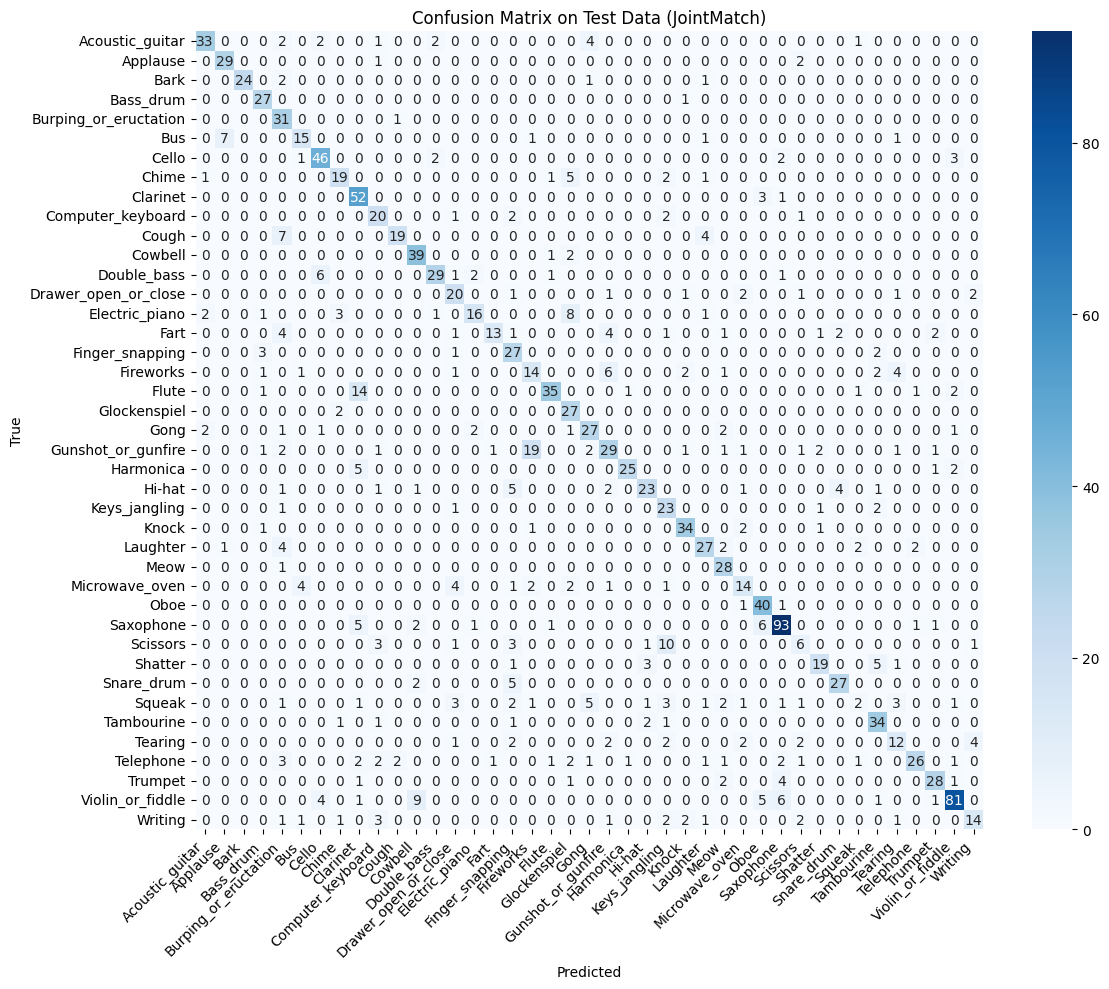

In [11]:
# ------------------------------------------
# 9. Evaluate on Test and Compute Metrics
# ------------------------------------------
test_loss, test_acc, y_pred, y_true = evaluate(model_f_best, test_loader, criterion_s, config.device)
print(f"\nFinal Test Results using Best Model (model_f):")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

print("\nClassification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

print("\nConfusion Matrix on Test Set:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data (JointMatch)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 10. Plot Training Curves

- Plot the supervised training loss, unsupervised training loss, training accuracy (on labeled data), and validation accuracy/loss over epochs.

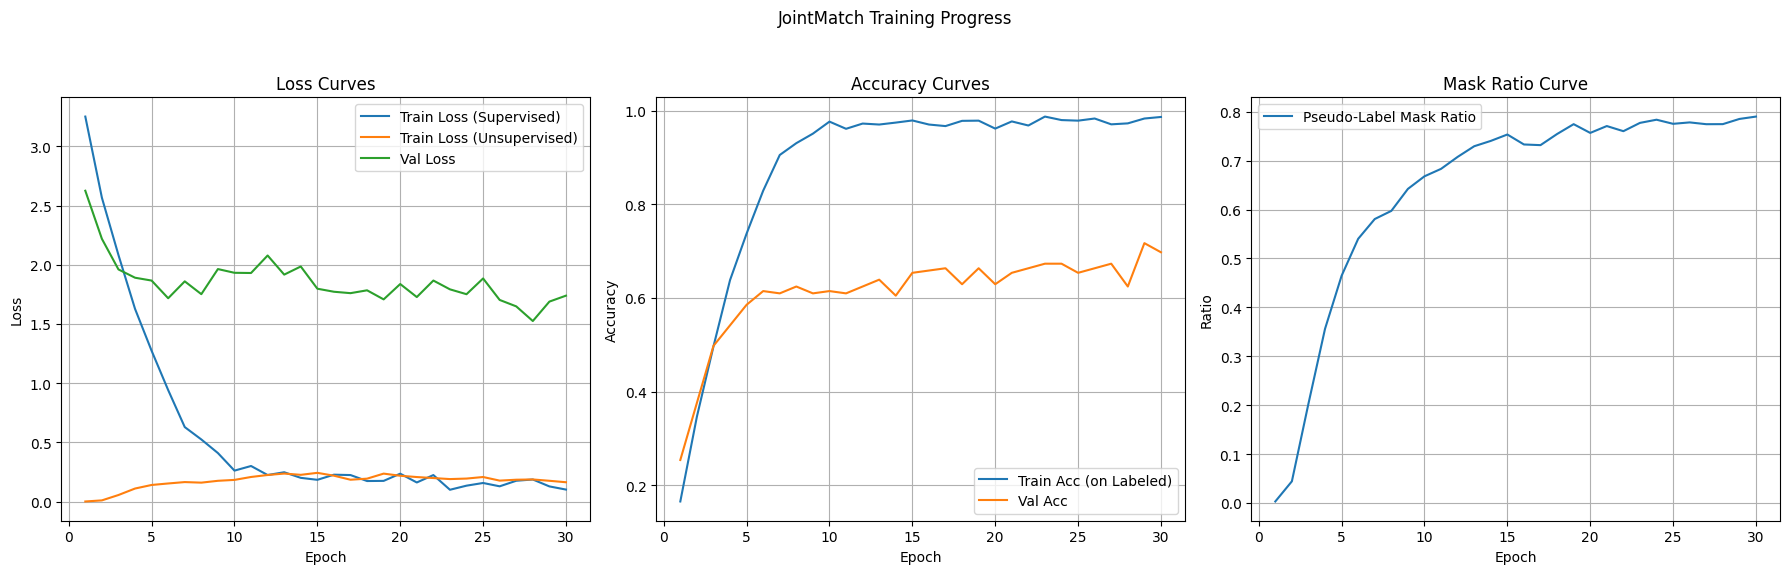

In [12]:
# ----------------------------
# 10. Plot Training Curves
# ----------------------------
epochs_range = range(1, config.epochs + 1)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses_s, label='Train Loss (Supervised)')
plt.plot(epochs_range, train_losses_u, label='Train Loss (Unsupervised)')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accs, label='Train Acc (on Labeled)')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, mask_ratios_log, label='Pseudo-Label Mask Ratio')
plt.xlabel('Epoch')
plt.ylabel('Ratio')
plt.title('Mask Ratio Curve')
plt.legend()
plt.grid(True)

plt.suptitle('JointMatch Training Progress')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()